In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lcdb

In [2]:
models = [
    "SVC_linear",
    "SVC_poly",
    "SVC_rbf",
    "SVC_sigmoid",
    "sklearn.tree.DecisionTreeClassifier",
    "sklearn.tree.ExtraTreeClassifier",
    "sklearn.linear_model.LogisticRegression",
    "sklearn.linear_model.PassiveAggressiveClassifier",
    "sklearn.linear_model.Perceptron",
    "sklearn.linear_model.RidgeClassifier",
    "sklearn.linear_model.SGDClassifier",
    "sklearn.neural_network.MLPClassifier",
#     "sklearn.discriminant_analysis.LinearDiscriminantAnalysis",
#     "sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis",
    "sklearn.naive_bayes.BernoulliNB",
#     "sklearn.naive_bayes.MultinomialNB",
    "sklearn.neighbors.KNeighborsClassifier",
    "sklearn.ensemble.ExtraTreesClassifier",
    "sklearn.ensemble.RandomForestClassifier",
    "sklearn.ensemble.GradientBoostingClassifier",
]


In [3]:
# find the largest dataset available
df_meta = lcdb.get_meta_features()
model = "SVC_linear"
mapping_id_to_nsamples = []
for task_id, name in zip(df_meta["openmlid"], df_meta["Name"]):
    try:
        curve = lcdb.get_curve(task_id, model)
    except Exception:
        continue
    anchors = curve[0]
    nsamples = anchors[-1]
    mapping_id_to_nsamples.append((task_id, nsamples))
mapping_id_to_nsamples = sorted(mapping_id_to_nsamples, key=lambda x: x[1])
mapping_id_to_nsamples

[(41157, 81),
 (1515, 461),
 (40981, 558),
 (188, 595),
 (1464, 605),
 (54, 684),
 (31, 810),
 (715, 810),
 (718, 810),
 (723, 810),
 (740, 810),
 (743, 810),
 (751, 810),
 (797, 810),
 (799, 810),
 (806, 810),
 (813, 810),
 (837, 810),
 (845, 810),
 (849, 810),
 (866, 810),
 (903, 810),
 (904, 810),
 (910, 810),
 (912, 810),
 (913, 810),
 (917, 810),
 (40971, 810),
 (392, 811),
 (679, 828),
 (741, 828),
 (401, 850),
 (1494, 854),
 (1468, 874),
 (1068, 898),
 (4137, 931),
 (934, 936),
 (897, 939),
 (930, 1053),
 (185, 1085),
 (966, 1085),
 (1049, 1180),
 (23, 1192),
 (181, 1201),
 (1457, 1215),
 (391, 1217),
 (1128, 1251),
 (1130, 1251),
 (1134, 1251),
 (1138, 1251),
 (1139, 1251),
 (1142, 1251),
 (1146, 1251),
 (1161, 1251),
 (1166, 1251),
 (398, 1263),
 (1050, 1265),
 (395, 1341),
 (21, 1399),
 (991, 1399),
 (40975, 1399),
 (40982, 1571),
 (12, 1620),
 (14, 1620),
 (16, 1620),
 (18, 1620),
 (22, 1620),
 (914, 1620),
 (962, 1620),
 (971, 1620),
 (978, 1620),
 (995, 1620),
 (1020, 1620

**If averaged out the functions are "well-behaved" but if taken individually they are noisy!**

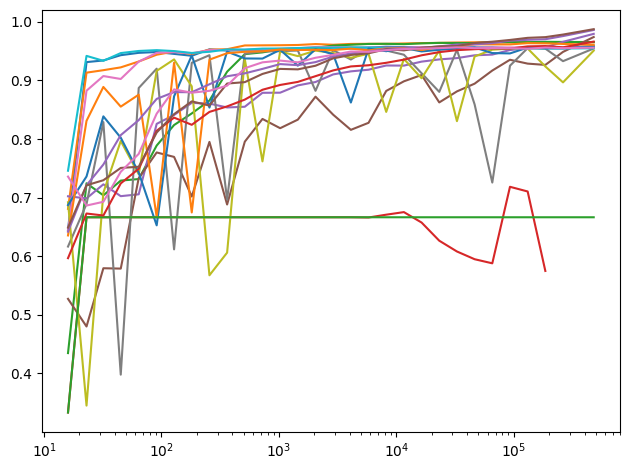

In [18]:
# task_id = 273 # strange curves
# task_id = 41150 # missing sklearn.naive_bayes.MultinomialNB
task_id = 351 # missing sklearn.naive_bayes.MultinomialNB

plt.figure()

for model in models:
    curve = lcdb.get_curve(task_id, model)
    anchors, _, scores_valid, _ = curve

    anchors = np.array(anchors)
    scores_valid = np.array([v[0] for v in scores_valid])
    plt.plot(anchors, scores_valid, label=model.split(".")[-1])

plt.xscale("log")
plt.tight_layout()
plt.show()

sklearn.neural_network.MLPClassifier
b_max: 370728
y_max=1.6531536527537933e-08
y_max=1.6531536527537933e-08
      fun: -0.4440884884079628
 hess_inv: array([[1]])
      jac: array([1.06170774e-06])
  message: 'Optimization terminated successfully.'
     nfev: 2
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([185372.])
b_opt=array([185372.])
y_max=1.6531536527537933e-08


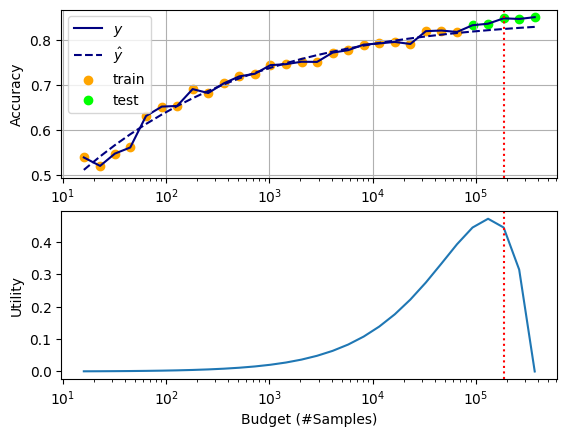

In [15]:
from functools import partial
from deephyper.stopper._lcmodel_stopper import f_mmf4, f_pow3, df_mmf4, u_nlog, normf
from deephyper.stopper._lcmodel_stopper import fit_learning_curve_model, maximize_utility


# task_id = 24

# Large tasks
# task_id = 354 # b_max: 524288
task_id = 293 # b_max: 370728
# task_id = 351 # b_max: 478565
# task_id = 41150 # b_max: 120064
model = models[11]
print(model)

def normf(b, rho, f, b_min, b_max, y_min=0, y_max=1):
    f_b_min, f_b_max = f(b_min, rho), f(b_max, rho)
    #print(f"{b_min=} - {b_max=}")
    # print(f"{f_b_min=} - {f_b_max=}")
    if f_b_min < f_b_max:
        f_min, f_max = f_b_min, f_b_max
    elif f_b_min > f_b_max:
        f_min, f_max = f_b_max, f_b_min
    else:
        f_min, f_max = 0, 1
    # print(f"{f_min=} - {f_max=}")
    y = f(b, rho)
    y = (y - f_min) / (f_max - f_min)  # mapped to [0, 1]
    y = y * (y_max - y_min) + y_min  # mapped to [y_min, y_max]
    return y

def nf_mmf4(b, rho):
    return normf(b, rho, f=f_mmf4, b_min=anchors[0], b_max=anchors[-1], y_min=0, y_max=1)
#     return normf(b, rho, f=f_mmf4, b_min=1, b_max=10e9, y_min=0, y_max=1)

f = f_mmf4
df = df_mmf4
k = 25
lamb = 0

curve = lcdb.get_curve(task_id, model)
anchors, _, scores_valid, _ = curve

anchors = np.array(anchors)
# len_first = len(scores_valid[0])
# scores_valid = [v for v in scores_valid if len(v) == len_first]
# scores_valid = np.array(scores_valid[:-1]).mean(axis=1)
scores_valid = np.array([v[0] for v in scores_valid])

b, y = anchors[:k], scores_valid[:k]
rho_hat = fit_learning_curve_model(f, b, y)

print(f"b_max: {anchors[-1]}")
b_opt = maximize_utility(u_nlog, f, df, rho_hat, lamb=[lamb], b_min=anchors[0], b_max=anchors[-1])
print(f"{b_opt=}")


# b_pred = [2**i for i in range(24)]
b_pred = anchors
y_hat = f(b_pred, rho_hat)
u_hat = u_nlog(b_pred, f, df, rho_hat, lamb=[lamb], b_max=anchors[-1])

plt.figure()

plt.subplot(2, 1, 1)
plt.plot(anchors, scores_valid, color="navy", label=r"$y$")
plt.plot(b_pred, y_hat, color="navy", linestyle="--", label=r"$\hat{y}$")
plt.scatter(b, y, color="orange", label="train")
plt.scatter(anchors[k:], scores_valid[k:], color="lime", label="test")
plt.axvline(b_opt, color="red", linestyle=":")
plt.legend()
plt.grid()
plt.ylabel("Accuracy")
plt.xscale("log")

plt.subplot(2, 1, 2)
plt.plot(anchors, u_hat)
plt.axvline(b_opt, color="red", linestyle=":")
plt.ylabel("Utility")
plt.xlabel("Budget (#Samples)")
plt.xscale("log")
# plt.yscale("log")

plt.show()

In [8]:
anchors

array([    16,     23,     32,     45,     64,     91,    128,    181,
          256,    362,    512,    724,   1024,   1448,   2048,   2896,
         4096,   5793,   8192,  11585,  16384,  23170,  32768,  46341,
        65536,  92682, 131072, 185364, 262144, 478565])

In [10]:
np.shape(scores_valid[:-1])

/Users/romainegele/miniforge3/envs/dh-arm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(30,)

In [22]:
task_id = 6
for model_i in models:
    curve = lcdb.get_curve(task_id, model_i)
    anchors, scores_train, scores_valid, scores_test = curve
    _, times = lcdb.get_train_times(task_id, model_i)
    times = np.asarray(times)
    #print(anchors)
    #print(times[:,0])
    #break

/var/folders/l8/8k8c8x8152zc16r3jw25gw0c0000gn/T/ipykernel_2393/808847016.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  times = np.asarray(times)


In [21]:
"""
---------------------------------------------------------------------------
Exception                                 Traceback (most recent call last)
Cell In [20], line 3
      1 task_id = 3
      2 for model_i in models:
----> 3     curve = lcdb.get_curve(task_id, model_i)
      4     anchors, scores_train, scores_valid, scores_test = curve
      5     _, times = lcdb.get_train_times(task_id, model_i)

File ~/miniforge3/envs/dh-arm/lib/python3.9/site-packages/lcdb/lcdb.py:623, in get_curve(dataset, learner, metric)
    620 def get_curve(dataset, learner, metric = "accuracy"):
--> 623     return get_curve_from_dataframe(get_curve_as_dataframe(dataset, learner, metric))

File ~/miniforge3/envs/dh-arm/lib/python3.9/site-packages/lcdb/lcdb.py:613, in get_curve_as_dataframe(dataset, learner, metric)
    611 df = df[(df["learner"] == learner)]
    612 if len(df) == 0:
--> 613     raise Exception(f"No curves found for learner {learner} on openmlid {openmlid}")
    614 return df

Exception: No curves found for learner sklearn.discriminant_analysis.LinearDiscriminantAnalysis on openmlid 3
"""

'\n---------------------------------------------------------------------------\nException                                 Traceback (most recent call last)\nCell In [20], line 3\n      1 task_id = 3\n      2 for model_i in models:\n----> 3     curve = lcdb.get_curve(task_id, model_i)\n      4     anchors, scores_train, scores_valid, scores_test = curve\n      5     _, times = lcdb.get_train_times(task_id, model_i)\n\nFile ~/miniforge3/envs/dh-arm/lib/python3.9/site-packages/lcdb/lcdb.py:623, in get_curve(dataset, learner, metric)\n    620 def get_curve(dataset, learner, metric = "accuracy"):\n--> 623     return get_curve_from_dataframe(get_curve_as_dataframe(dataset, learner, metric))\n\nFile ~/miniforge3/envs/dh-arm/lib/python3.9/site-packages/lcdb/lcdb.py:613, in get_curve_as_dataframe(dataset, learner, metric)\n    611 df = df[(df["learner"] == learner)]\n    612 if len(df) == 0:\n--> 613     raise Exception(f"No curves found for learner {learner} on openmlid {openmlid}")\n    614 r

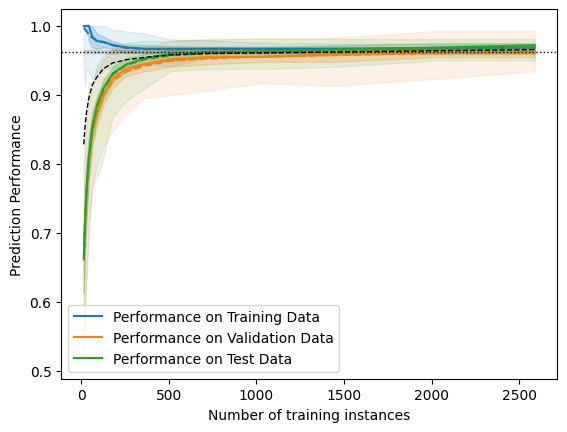

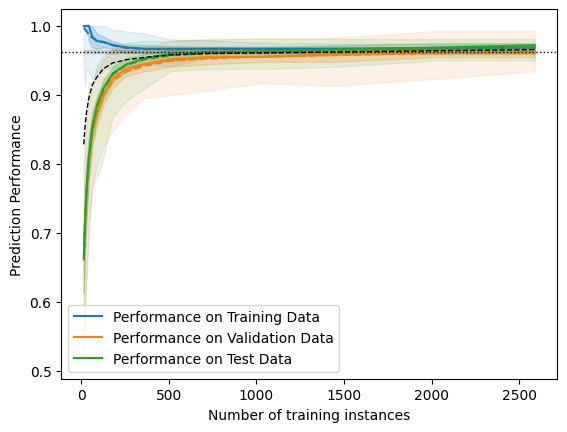

In [4]:
lcdb.plot_train_and_test_curve(curve)

In [5]:
anchors

[16, 23, 32, 45, 64, 91, 128, 181, 256, 362, 512, 724, 1024, 1448, 2048, 2588]

In [8]:
import numpy as np

print(np.shape(scores_train))
print(np.shape(scores_valid))
print(np.shape(scores_test))

(16, 125)
(16, 125)
(16, 125)


In [9]:
print(np.shape(anchors))

(16,)


In [11]:
anchors, times = lcdb.get_train_times(3, "sklearn.linear_model.LogisticRegression")

In [12]:
times

[[0.0145,
  0.0128,
  0.0153,
  0.0132,
  0.0142,
  0.0179,
  0.0147,
  0.0126,
  0.0129,
  0.0113,
  0.0186,
  0.0132,
  0.0108,
  0.0124,
  0.0133,
  0.0296,
  0.0176,
  0.0135,
  0.0176,
  0.0144,
  0.0193,
  0.0158,
  0.0123,
  0.0153,
  0.0147,
  0.0152,
  0.0115,
  0.0154,
  0.0145,
  0.0139,
  0.017,
  0.0139,
  0.0127,
  0.0136,
  0.01,
  0.0148,
  0.0141,
  0.0147,
  0.0146,
  0.0126,
  0.0162,
  0.014,
  0.0145,
  0.0193,
  0.0185,
  0.016,
  0.0138,
  0.0127,
  0.0152,
  0.0126,
  0.0161,
  0.0105,
  0.0139,
  0.0151,
  0.0126,
  0.0266,
  0.0171,
  0.014,
  0.0141,
  0.0132,
  0.0161,
  0.0133,
  0.0132,
  0.0149,
  0.0119,
  0.0203,
  0.0137,
  0.0132,
  0.0148,
  0.0123,
  0.0188,
  0.013,
  0.0141,
  0.0133,
  0.013,
  0.0143,
  0.0112,
  0.0127,
  0.0149,
  0.015,
  0.02,
  0.0141,
  0.0129,
  0.0113,
  0.0106,
  0.0137,
  0.015,
  0.0118,
  0.0158,
  0.011,
  0.0216,
  0.0174,
  0.0162,
  0.0158,
  0.0113,
  0.0151,
  0.0124,
  0.0123,
  0.0154,
  0.0117,
  0.0152,
  0

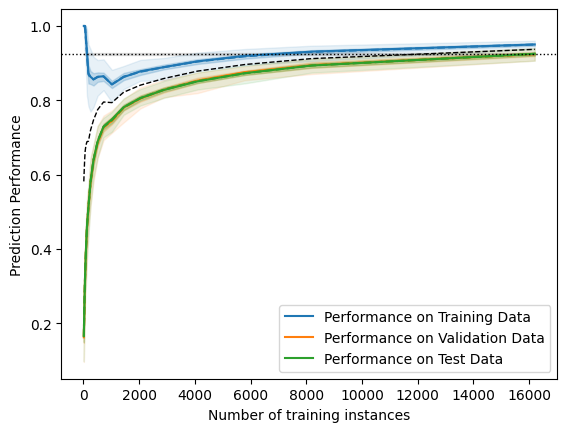

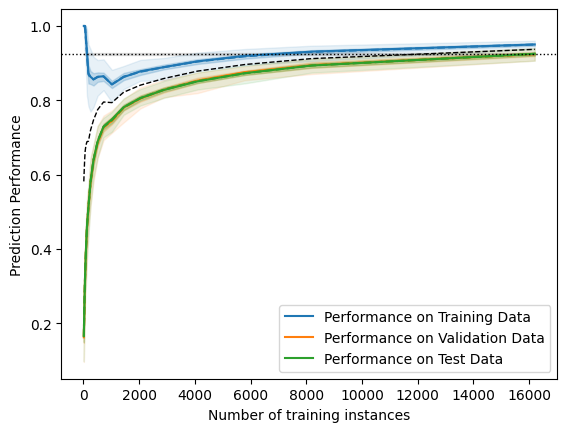

In [17]:
task_id = 6
learner = "sklearn.neural_network.MLPClassifier"
curve = lcdb.get_curve(task_id, learner)
lcdb.plot_train_and_test_curve(curve)

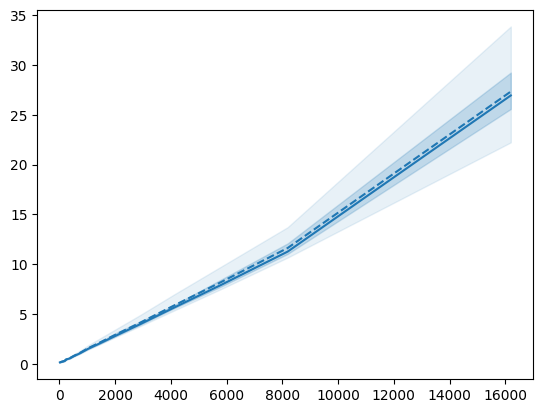

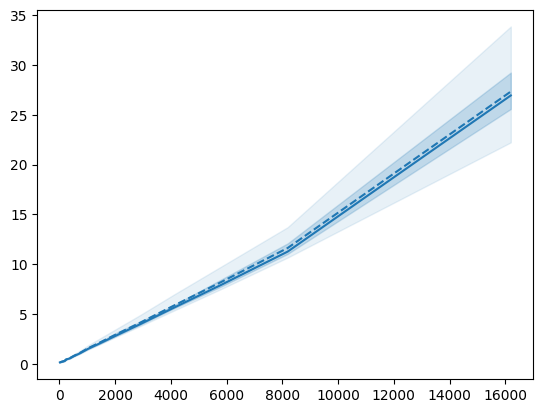

In [31]:
lcdb.plot_train_times(task_id, learner)

In [19]:
anchors, times = lcdb.get_train_times(task_id, learner)

In [22]:
len(times[0])

125

In [24]:
len(curve[0])

20

In [25]:
np.shape(times)

(20, 125)

In [28]:
times = np.asarray(times)
times[:,0]

array([ 0.1428,  0.1453,  0.1482,  0.1625,  0.177 ,  0.2109,  0.2298,
        0.2714,  0.4434,  0.5098,  0.7473,  1.0045,  1.4611,  1.9896,
        2.9158,  4.417 ,  5.5747,  7.5956, 10.8479, 28.8627])

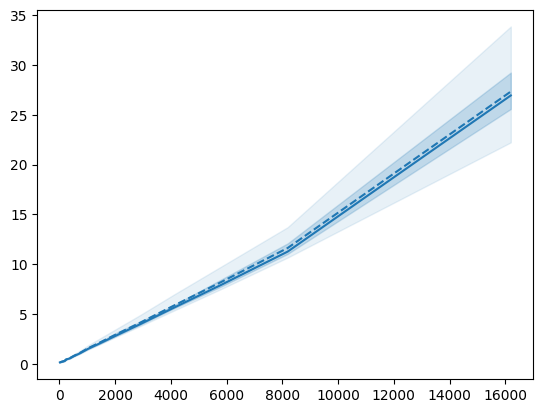

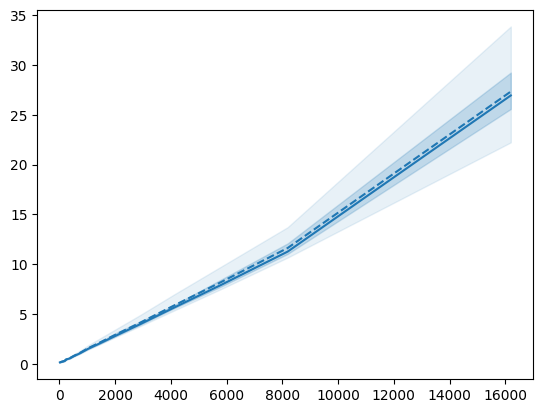

In [30]:
lcdb.plot_train_times(task_id, learner)

In [32]:
models = [
    "SVC_linear",
    "SVC_poly",
    "SVC_rbf",
    "SVC_sigmoid",
    "sklearn.tree.DecisionTreeClassifier",
    "sklearn.tree.ExtraTreeClassifier",
    "sklearn.linear_model.LogisticRegression",
    "sklearn.linear_model.PassiveAggressiveClassifier",
    "sklearn.linear_model.Perceptron",
    "sklearn.linear_model.RidgeClassifier",
    "sklearn.linear_model.SGDClassifier",
    "sklearn.neural_network.MLPClassifier",
    "sklearn.discriminant_analysis.LinearDiscriminantAnalysis",
    "sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis",
    "sklearn.naive_bayes.BernoulliNB",
    "sklearn.naive_bayes.MultinomialNB",
    "sklearn.neighbors.KNeighborsClassifier",
    "sklearn.ensemble.ExtraTreesClassifier",
    "sklearn.ensemble.RandomForestClassifier",
    "sklearn.ensemble.GradientBoostingClassifier",
]

task_ids = []

In [ ]:
"""
3 (kr-vs-kp)
6 (letter)
12 (mfeat-factors)
14 (mfeat-fourier)
16 (mfeat-karhunen)
18 (mfeat-morphological)
21 (car)
22 (mfeat-zernike)
23 (cmc)
24 (mushroom)
26 (nursery)
28 (optdigits)
30 (page-blocks)
31 (credit-g)
32 (pendigits)
36 (segment)
38 (sick)
44 (spambase)
46 (splice)
54 (vehicle)
57 (hypothyroid)
60 (waveform-5000)
179 (adult)
180 (covertype)
181 (yeast)
182 (satimage)
183 (abalone)
184 (kropt)
185 (baseball)
188 (eucalyptus)
273 (IMDB.drama)
293 (covertype)
300 (isolet)
351 (codrna)
354 (poker)
357 (vehicle_sensIT)
389 (fbis.wc)
390 (new3s.wc)
391 (re0.wc)
392 (oh0.wc)
393 (la2s.wc)
395 (re1.wc)
396 (la1s.wc)
398 (wap.wc)
399 (ohscal.wc)
401 (oh10.wc)
485 (analcatdata_vehicle)
554 (mnist_784)
679 (rmftsa_sleepdata)
715 (fri_c3_1000_25)
718 (fri_c4_1000_100)
720 (abalone)
722 (pol)
723 (fri_c4_1000_25)
727 (2dplanes)
728 (analcatdata_supreme)
734 (ailerons)
735 (cpu_small)
737 (space_ga)
740 (fri_c3_1000_10)
741 (rmftsa_sleepdata)
743 (fri_c1_1000_5)
751 (fri_c4_1000_10)
752 (puma32H)
761 (cpu_act)
772 (quake)
797 (fri_c4_1000_50)
799 (fri_c0_1000_5)
803 (delta_ailerons)
806 (fri_c3_1000_50)
807 (kin8nm)
813 (fri_c3_1000_5)
816 (puma8NH)
819 (delta_elevators)
821 (house_16H)
822 (cal_housing)
823 (houses)
833 (bank32nh)
837 (fri_c1_1000_50)
843 (house_8L)
845 (fri_c0_1000_10)
846 (elevators)
847 (wind)
849 (fri_c0_1000_25)
866 (fri_c2_1000_50)
871 (pollen)
881 (mv)
897 (colleges_aaup)
901 (fried)
903 (fri_c2_1000_25)
904 (fri_c0_1000_50)
910 (fri_c1_1000_10)
912 (fri_c2_1000_5)
913 (fri_c2_1000_10)
914 (balloon)
917 (fri_c1_1000_25)
923 (visualizing_soil)
930 (colleges_usnews)
934 (socmob)
953 (splice)
958 (segment)
959 (nursery)
962 (mfeat-morphological)
966 (analcatdata_halloffame)
971 (mfeat-fourier)
976 (JapaneseVowels)
977 (letter)
978 (mfeat-factors)
979 (waveform-5000)
980 (optdigits)
991 (car)
993 (kdd_ipums_la_97-small)
995 (mfeat-zernike)
1000 (hypothyroid)
1002 (ipums_la_98-small)
1018 (ipums_la_99-small)
1019 (pendigits)
1020 (mfeat-karhunen)
1021 (page-blocks)
1036 (sylva_agnostic)
1037 (ada_prior)
1039 (hiva_agnostic)
1040 (sylva_prior)
1041 (gina_prior2)
1042 (gina_prior)
1049 (pc4)
1050 (pc3)
1053 (jm1)
1059 (ar1)
1067 (kc1)
1068 (pc1)
1069 (pc2)
1111 (KDDCup09_appetency)
1116 (musk)
1119 (adult-census)
1120 (MagicTelescope)
1128 (OVA_Breast)
1130 (OVA_Lung)
1134 (OVA_Kidney)
1138 (OVA_Uterus)
1139 (OVA_Omentum)
1142 (OVA_Endometrium)
1146 (OVA_Prostate)
1161 (OVA_Colon)
1166 (OVA_Ovary)
1216 (Click_prediction_small)
1242 (vehicleNorm)
1457 (amazon-commerce-reviews)
1461 (bank-marketing)
1464 (blood-transfusion-service-center)
1468 (cnae-9)
1475 (first-order-theorem-proving)
1485 (madelon)
1486 (nomao)
1487 (ozone-level-8hr)
1489 (phoneme)
1494 (qsar-biodeg)
1501 (semeion)
1515 (micro-mass)
1569 (poker-hand)
1590 (adult)
4134 (Bioresponse)
4135 (Amazon_employee_access)
4136 (Dexter)
4137 (Dorothea)
4534 (PhishingWebsites)
4538 (GesturePhaseSegmentationProcessed)
4541 (Diabetes130US)
4552 (BachChoralHarmony)
23380 (cjs)
23512 (higgs)
23517 (numerai28.6)
40497 (thyroid-ann)
40498 (wine-quality-white)
40668 (connect-4)
40670 (dna)
40685 (shuttle)
40691 (wine-quality-red)
40701 (churn)
40900 (Satellite)
40926 (CIFAR_10_small)
40971 (collins)
40975 (car)
40978 (Internet-Advertisements)
40981 (Australian)
40982 (steel-plates-fault)
40983 (wilt)
40984 (segment)
40996 (Fashion-MNIST)
41026 (gisette)
41027 (jungle_chess_2pcs_raw_endgame_complete)
41064 (convex)
41065 (mnist_rotation)
41066 (secom)
41138 (APSFailure)
41142 (christine)
41143 (jasmine)
41144 (madeline)
41145 (philippine)
41146 (sylvine)
41147 (albert)
41150 (MiniBooNE)
41156 (ada)
41157 (arcene)
41158 (gina)
41159 (guillermo)
41161 (riccardo)
41162 (kick)
41163 (dilbert)
41164 (fabert)
41165 (robert)
41166 (volkert)
41167 (dionis)
41168 (jannis)
41169 (helena)
41946 (Sick_numeric)
42732 (sf-police-incidents)
42733 (Click_prediction_small)
42734 (okcupid-stem)
"""

In [33]:
lcdb.get_openmlid_from_descriptor("pendigits")

Exception: Ambigous dataset name found pendigits. There are 2 datasets with this name.

In [4]:
df_meta = lcdb.get_meta_features()
df_meta[df_meta["Name"] == "pendigits"]

,openmlid,Name,AutoCorrelation,ClassEntropy,Dimensionality,EquivalentNumberOfAtts,MajorityClassSize,MaxAttributeEntropy,MaxKurtosisOfNumericAtts,MaxMeansOfNumericAtts,...,Quartile2MutualInformation,Quartile2SkewnessOfNumericAtts,Quartile2StdDevOfNumericAtts,Quartile3AttributeEntropy,Quartile3KurtosisOfNumericAtts,Quartile3MeansOfNumericAtts,Quartile3MutualInformation,Quartile3SkewnessOfNumericAtts,Quartile3StdDevOfNumericAtts,NumberOfFeaturesAfterBinarization
14,32,pendigits,0.102902,3.320772,0.001547,NaN,1144.0,NaN,3.050747,85.120269,...,NaN,0.086459,30.241492,NaN,-0.260617,59.604417,NaN,0.447357,34.227219,16
116,1019,pendigits,0.813120,0.481784,0.001547,NaN,9848.0,NaN,3.050747,85.120269,...,NaN,0.086459,30.241492,NaN,-0.260617,59.604417,NaN,0.447357,34.227219,16


$$\frac{b^{\rho_{3}} \rho_{3} \left(- \frac{2 b^{\rho_{3}} \rho_{2} \rho_{3}}{b^{\rho_{3}} + \rho_{1}} + \rho_{2} \left(\rho_{3} - 1\right) + \frac{\left(b^{\rho_{3}} \rho_{2} + \rho_{0} \rho_{1}\right) \left(\frac{2 b^{\rho_{3}} \rho_{3}}{b^{\rho_{3}} + \rho_{1}} - \rho_{3} + 1\right)}{b^{\rho_{3}} + \rho_{1}}\right)}{b^{2} \left(b^{\rho_{3}} + \rho_{1}\right)}$$

$$f_\text{mmf4}(b;\rho) = \frac{\rho_0 \rho_1 + \rho_2 b^{\rho_3}}{\rho_1 + b^{\rho_3}}$$